In [1]:
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from helper import *
from sklearn.model_selection import GridSearchCV

# Supress all warnings
import warnings
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
from matplotlib.patches import Patch
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

_Plotting Functions_

In [2]:
def plot_feature_importance(coefficients, features, n=10, omics_labels=None):
    """
    :param coefficients: The coefficients determining feature importance
    :param features: The names of the features
    :param n: Number of top features to plot
    :param omics_labels: List of labels for the omics data (Lipidomics, Metabolomics, Proteomics)
    """

    feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients})
    if omics_labels is not None:
        feature_importance['Omics'] = omics_labels
    # Add the absolute importance
    feature_importance['Absolute Importance'] = abs(feature_importance['Importance'])
    # Sort the features based on the absolute value of the coefficient
    feature_importance = feature_importance.sort_values('Absolute Importance', ascending=True)
    
    # Select the top n features
    feature_importance = feature_importance[-n:]
    
    plt.figure(figsize=(12, 8))
    if not omics_labels:
        plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    else:
        values = np.unique(omics_labels)
        color_mapping = dict(zip(values, sns.color_palette('husl', len(values))))
        # Fill with gray if the omics data is not provided
        # Otherwise, use the color mapping to color the bars
        feature_importance['Color'] = (
            feature_importance['Omics'].map(color_mapping).fillna('gray'))
        plt.barh(
            feature_importance['Feature'], 
            feature_importance['Importance'],
            color=feature_importance['Color']
        )
        # Add a legend for the omics data
        patches = [
            plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in color_mapping]
        plt.legend(
            patches, color_mapping.keys(), 
            loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.,
            title='Omics Type', title_fontsize='large', fontsize='large'
        )
        
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance', fontsize=16)
    plt.show()

# Load the Data

In [3]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"
xls = pd.ExcelFile(path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")

# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

Training set shape:  (58, 1118)
Testing set shape:  (38, 1118)


In [4]:
feature_names = X_train.columns
omics_labels = [get_omics_type(feature) for feature in feature_names]

Add mapping of the classes

In [5]:
class_mapping = {1 : 0, 2 : 1}
# Mapping the classes
Y_train = Y_train.map(class_mapping)
y_test = y_test.map(class_mapping)
print(np.unique(Y_train))
print(np.unique(y_test))

[0 1]
[0 1]


Standardizing the data (crucial for regularized models)

In [6]:
def standardize(X):
    """
    Standardize the data using the StandardScaler
    This is crucial for regularized models
    (otherwise features with larger scales dominate the regularization)
    :param X: Data
    """
    scaler = StandardScaler()
    return scaler.fit_transform(X)

In [7]:
# Standardize the data
X_train = standardize(X_train)
X_test = standardize(X_test)

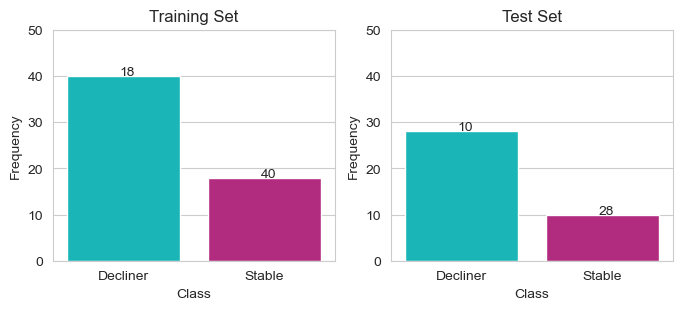

In [8]:
# Create a plot of the distribution of the classes in the training set
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

colors = ['darkturquoise', 'mediumvioletred']
labels = {0: 'Stable', 1: 'Decliner'}
Y_train_labels = Y_train.map(labels)
y_test_labels = y_test.map(labels)

Y_train_count, y_test_count = Y_train_labels.value_counts(), y_test_labels.value_counts()
y_lim = max(Y_train_count.max(), y_test_count.max()) + 10

# Add the count of each class on top of the bars
sns.barplot(x=Y_train_count.index, y=Y_train_count.values, ax=axs[0], palette=colors)

for p, label in zip(axs[0].patches, Y_train_count.values[::-1]):
    axs[0].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
axs[0].set_title("Training Set")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")
axs[0].set_ylim(0, y_lim)

sns.barplot(x=y_test_count.index, y=y_test_count.values, ax=axs[1], palette=colors)
for p, label in zip(axs[1].patches, y_test_count.values[::-1]):
    axs[1].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

axs[1].set_title("Test Set")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")
axs[1].set_ylim(0, y_lim)
plt.show()


# Logistic Regression

### 1. No Regularization

In [9]:
# Fit the model
model = LogisticRegression(
    max_iter=1000,
    multi_class='ovr', # Binary classification
    class_weight='balanced',
    penalty='none', # No regularization
).fit(X_train, Y_train)

Accuracy of the model: 0.5789
Recall of the model: 0.5789
Precision of the model: 0.5850
F1 score of the model: 0.5539


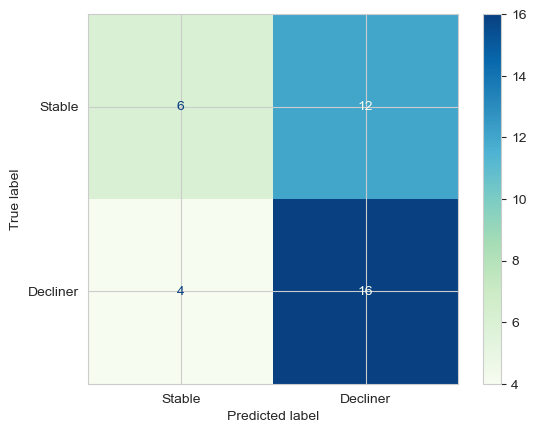

In [10]:
# Evaluate the model
evaluate_model(y_test, model.predict(X_test))

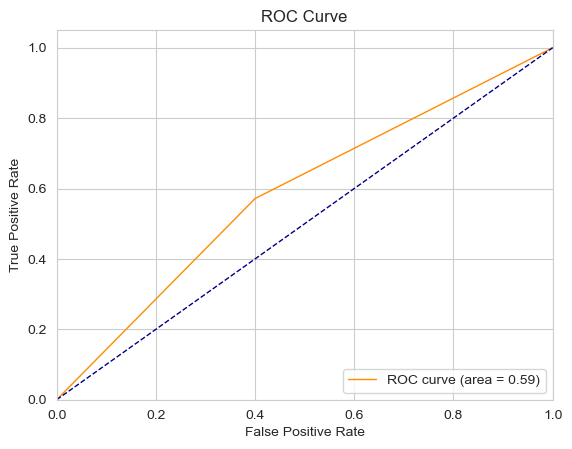

In [11]:
y_pred = model.predict(X_test)
plot_ROC_curve(y_pred, y_test, X_test)

### Hyperparameter Tuning - Regularization

In [12]:
hyperparams = {
    # Inverse of regularization strength
    'C': [5, 1.0, 0.8, 0.6, 0.4, 0.1, 0.01],
}

# Fit the model using grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=1000,
        multi_class='ovr', # Binary classification
        class_weight='balanced',
        penalty='l1', # Lasso Regularization
        solver='saga',
    ),
    param_grid=hyperparams,
    scoring='recall',
    cv=10,
    n_jobs=-1
).fit(X_train, Y_train)

{'C': 0.6}
Accuracy of the model: 0.7368
Recall of the model: 0.7368
Precision of the model: 0.7271
F1 score of the model: 0.7298


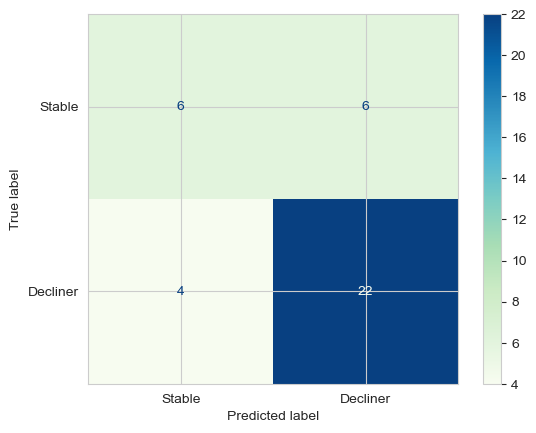

Penalty term: 1.67


In [13]:
# Print the best hyperparameters
print(grid_search.best_params_)
evaluate_model(y_test, grid_search.predict(X_test))
best_model = grid_search.best_estimator_

print('Penalty term:', round(1 / best_model.C, 2))

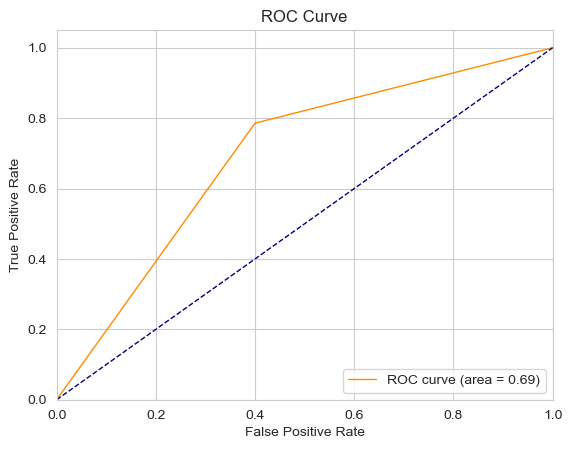

In [14]:
y_pred = best_model.predict(X_test)
plot_ROC_curve(y_pred, y_test, X_test)

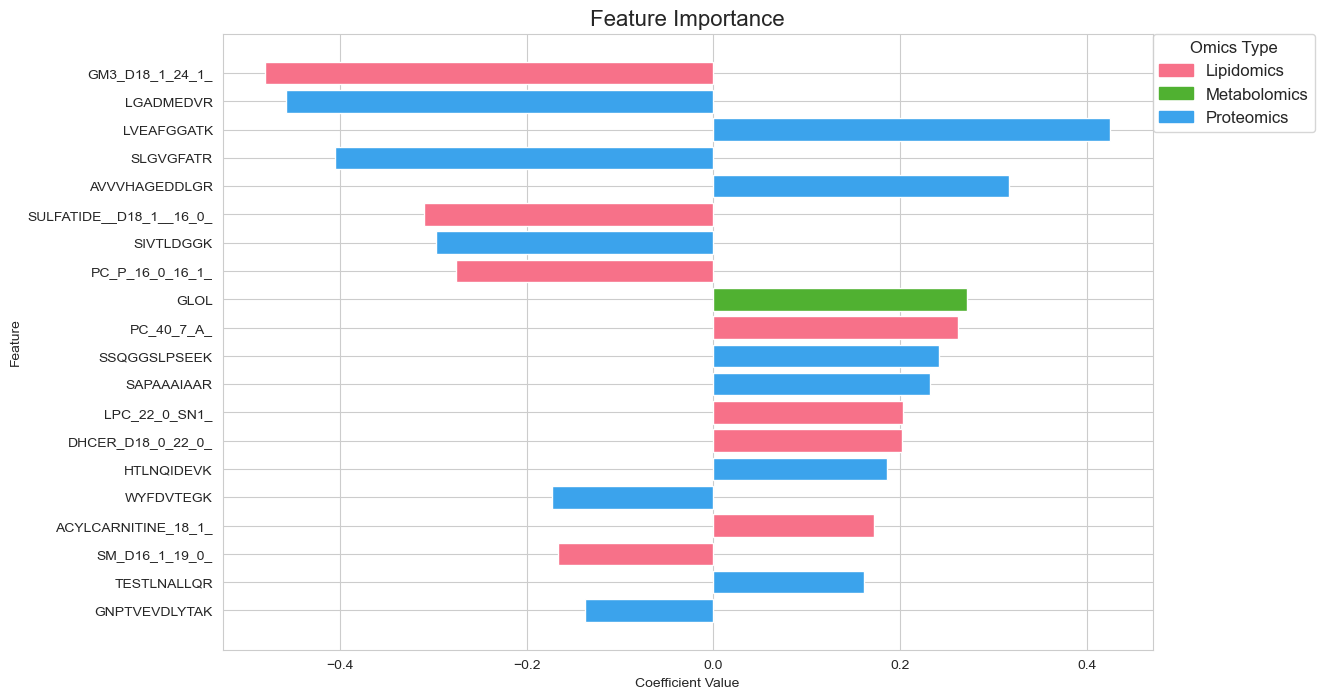

In [15]:
plot_feature_importance(
    best_model.coef_[0], feature_names, n=20, omics_labels=omics_labels)

## Feature Selection
Based on the coefficients of the model, we can select the most important features and remove the ones with 0 coefficients.

Number of features with 0 coefficients: 1063 out of 1111


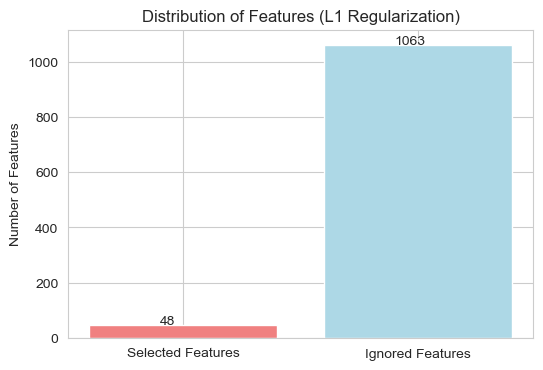

In [17]:
# Get the features with 0 coefficients
coefficients = best_model.coef_[0]
zero_features = np.where(coefficients == 0)[0]

print(f'Number of features with 0 coefficients: {len(zero_features)} out of {len(feature_names)}')

# Create a plot to show the distribution 0 / non-0 coefficients
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    ['Selected Features', 'Ignored Features'], 
    [len(coefficients) - len(zero_features), len(zero_features)],
    color=['lightcoral', 'lightblue'])
ax.set_ylabel('Number of Features')
# Add the count of each class on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+1))
ax.set_title('Distribution of Features (L1 Regularization)')  
plt.show()

In [18]:
non_zero_features = np.where(coefficients != 0)[0]
non_zero_features_names = np.array(feature_names)[non_zero_features]
features_data = []
for feature, coef in zip(non_zero_features_names, coefficients[non_zero_features]):
    data_type = get_omics_type(feature)
    features_data.append({'Feature': feature, 'Coefficient': coef, 'Type': data_type})
features_df = pd.DataFrame(features_data)

In [19]:
# Create a dataframe with columns for each data type
plot_df = pd.DataFrame(columns=['Lipidomics', 'Metabolomics', 'Proteomics'])
# Add initial distribution of the features
plot_df.loc['Initial'] = [
    len(lipidomics.columns) - 3, 
    len(metabolomics.columns) - 3, 
    len(proteomics.columns) - 3]
# Add the distribution of the selected features
plot_df.loc['Selected'] = features_df['Type'].value_counts()
print(plot_df)

          Lipidomics  Metabolomics  Proteomics
Initial          578           213         320
Selected          27             2          19


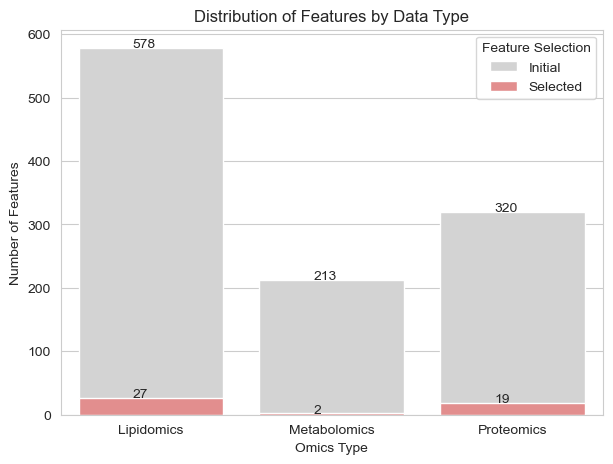

In [20]:
# Plot distribution among the omics data
fig, ax = plt.subplots(figsize=(7, 5))

# Plot initial distribution
sns.barplot(data=plot_df.T, x=plot_df.columns, y='Initial', color='lightgrey', label='Initial')
# Plot selected features
sns.barplot(data=plot_df.T, x=plot_df.columns, y='Selected', color='lightcoral', label='Selected')

# Add the count of each class on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+1))

ax.set_ylabel('Number of Features')
ax.set_xlabel('Omics Type')
ax.set_title('Distribution of Features by Data Type')
plt.legend(title='Feature Selection')
plt.show()


In [21]:
# Save the feature names in a text file
path = 'C:/Users/mjgoj/PycharmProjects/ThesisFinal/insignificant/selected_features_logistic_regression.txt'
with open(path, 'w') as f:
    for feature in non_zero_features_names:
        f.write(f'{feature}\n')

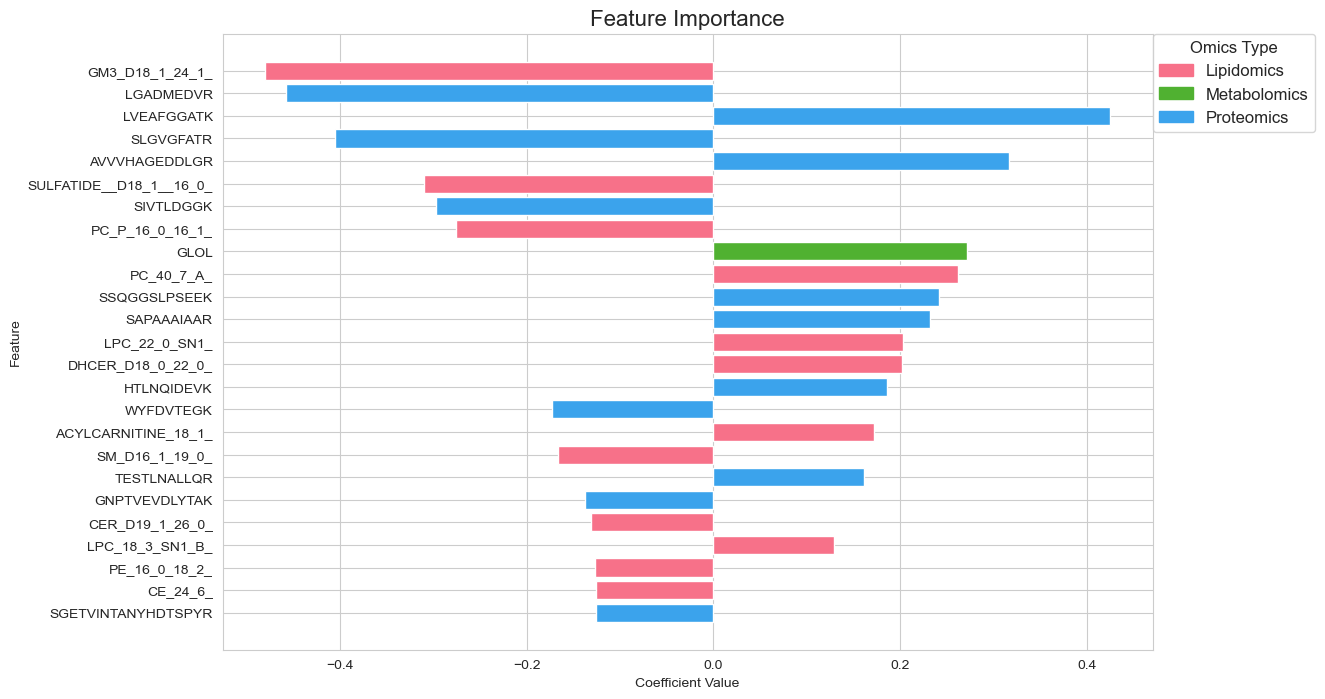

In [23]:
coefficients = best_model.coef_[0]
plot_feature_importance(
    coefficients, feature_names, n=25, omics_labels=omics_labels)

# SHAP (SHapley Additive exPlanations)

Quantifies the impact of each feature on the model's output

In [ ]:
explainer = shap.Explainer(
    grid_search.best_estimator_, X_train, feature_names=feature_names
)
# Compute SHAP values for each prediction made on the test data 
shap_values = explainer(X_test)

### SHAP Summary Plot

Shows SHAP values for all the features from the dataset, ordered by the sum of SHAP value magnitudes over all samples. The feature at the top has the highest overall impact on model output.

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=10)

# LIME (Local Interpretable Model-agnostic Explanations)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, mode='classification', feature_names=feature_names
)

In [ ]:
def LIME_explain_sample(sample_idx):
    true_class = y_test.iloc[sample_idx]
    print(f'True Class: {true_class}')
    
    sample = X_test[sample_idx]
    explanation = explainer.explain_instance(
        sample, grid_search.predict_proba, num_features=10, top_labels=1
    )
    explanation.show_in_notebook()
    
    explanation.as_pyplot_figure(label=0)

In [ ]:
LIME_explain_sample(2)